In [1]:
import torch
print("PyTorch Version:", torch.__version__)
print("\n--- Build Configuration ---")
print(torch.__config__.show())

print("\n--- Parallelism Info ---")
print(f"MKL Available: {torch.backends.mkl.is_available()}")
if torch.backends.mkl.is_available():
    # 这一步通常无法直接打印版本号，但可以通过 config show 看出来
    pass
print(f"OpenMP Available: {torch.backends.openmp.is_available()}")

PyTorch Version: 2.9.0+cu128

--- Build Configuration ---
PyTorch built with:
  - GCC 13.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.9
  - Built with CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90;-gencode;arch=compute_100,code=sm_100;-gencode;arch=compute_120,code=sm_120
  - CuDNN 91.5.1  (built against CUDA 12.9)
    - Built with CuDNN 90.8
  - Magma 2.6.1
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, COMMIT_SHA=0fabc3ba44823f257e70ce397d989c8de5e362c1, CUDA_VERSI

In [ ]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ["OMP_NUM_THREADS"] = '1'
from vmap_utils import random_initial_config, compute_grads, sample_next, evaluate_energy
from vmap_models import Transformer_fPEPS_Model_Conv2d, Transformer_fPEPS_Model, Transformer_fPEPS_Model_GlobalMLP
import pickle
import quimb.tensor as qtn
from vmc_torch.hamiltonian_torch import spinful_Fermi_Hubbard_square_lattice_torch
import symmray as sr
import time
import torch
from vmap_modules import use_jitter_svd, vmap_friendly_svd
torch.linalg.svd = vmap_friendly_svd

# System parameters
Lx = 8
Ly = 8
nsites = Lx * Ly
D = 8
seed = 42
flat = True

# Load PEPS
pwd = '/home/sijingdu/TNVMC/VMC_code/vmc_torch/vmc_torch/experiment/vmap/data'
u1z2 = True
appendix = '_U1SU' if u1z2 else ''
t = 1.0
U = 8.0
N_f = nsites - 8
try:
    params_path = f'{pwd}/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/Z2/D={D}/'
    params = pickle.load(open(params_path + f'peps_su_params{appendix}.pkl', 'rb'))
    skeleton = pickle.load(open(params_path + f'peps_skeleton{appendix}.pkl', 'rb'))
    peps = qtn.unpack(params, skeleton)
    for ts in peps.tensors: 
        ts.modify(data=ts.data.to_flat()*4)
    for site in peps.sites: 
        peps[site].data._label = site
        peps[site].data.indices[-1]._linearmap = ((0, 0), (1, 0), (1, 1), (0, 1)) # Important for U1->Z2 fPEPS
except:
    print("Cannot find saved fPEPS, generating a random one...")
    # random fPEPS
    peps = sr.networks.PEPS_fermionic_rand(
        "Z2",
        Lx,
        Ly,
        D,
        phys_dim=[
            (0, 0),  # linear index 0 -> charge 0, offset 0
            (1, 1),  # linear index 1 -> charge 1, offset 1
            (1, 0),  # linear index 2 -> charge 1, offset 0
            (0, 1),  # linear index 3 -> charge 0, offset 1
        ],  # -> (0, 3), (2, 1)
        # put an odd number of odd sites in, for testing
        # site_charge=lambda site: int(site in [(0, 0), (0, 1), (1, 0)]),
        subsizes="equal",
        flat=flat,
        seed=seed,
    )

# Hamiltonian
H = spinful_Fermi_Hubbard_square_lattice_torch(
    Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=(N_f//2, N_f//2), no_u1_symmetry=False,
)

model_config = {
    'max_bond': 2*D,
    'embed_dim': 16,
    'attn_depth': 1,
    'attn_heads': 4,
    'nn_hidden_dim': peps.nsites,
    'init_perturbation_scale': 1e-3,
    'nn_eta': 1,
    'dtype_str': 'float64' 
}
dtype_map = {'float64': torch.float64, 'float32': torch.float32}
model_dtype = dtype_map[model_config['dtype_str']]
init_kwargs = model_config.copy()
init_kwargs.pop('dtype_str')

model = Transformer_fPEPS_Model_Conv2d(
    tn=peps,
    dtype=model_dtype,
    **init_kwargs
)
# # Load Checkpoint
# file_path = f'{params_path}/{model._get_name()}/chi={model.chi}/'
# ckpt_path = file_path + 'model_state.pt'
# model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))

# err_fxs = torch.load(file_path+'error_input.pt', map_location='cpu')
# err_fx = torch.tensor([2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1, 2, 1,
#         2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 0, 2, 0, 0, 1, 2, 0, 2, 2,
#         2, 2, 0, 2, 0, 3, 1, 0, 2, 1, 3, 1, 3, 1, 2, 1])
# with torch.no_grad():
#     amp = model(err_fx.unsqueeze(0))
# print(amp)
# with use_jitter_svd():
#     amps = model(err_fxs)
# print(amps)

 -> Clamping output layer (Conv2d) weights to scale 0.001


In [2]:
ftn_params_vec = torch.nn.utils.parameters_to_vector(model.ftn_params)
fxs = []
for _ in range(2):
    fxs.append(random_initial_config(N_f, nsites))
fxs = torch.stack(fxs, dim=0)
ftn_params_vec.mean(), ftn_params_vec.std(), ftn_params_vec.max(), model(fxs)

(tensor(8.7287e-05, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0566, dtype=torch.float64, grad_fn=<StdBackward0>),
 tensor(2.4321, dtype=torch.float64, grad_fn=<MaxBackward1>),
 tensor([2.7421e-13, 4.8997e-09], dtype=torch.float64, grad_fn=<MulBackward0>))

In [7]:
# Prepare initial samples
# batchsize per rank
B_list = [1, 8, 16, 20, 24, 28, 32, 36, 40]
time_list = []
grad_time_list = []

for B in B_list:
    fxs = []
    for _ in range(B):
        fxs.append(random_initial_config(N_f, nsites))
    fxs = torch.stack(fxs, dim=0)
    print(f"Batch size: {B}")
    model = Transformer_fPEPS_Model_Conv2d(
        tn=peps,
        dtype=model_dtype,
        **init_kwargs
    )
    # model = Transformer_fPEPS_Model_GlobalMLP(
    #     tn=peps,
    #     max_bond=-1,
    #     embed_dim=16,
    #     attn_heads=4,
    #     attn_depth=1,
    #     nn_hidden_dim=2*peps.nsites,
    #     nn_eta=1,
    #     init_perturbation_scale=1e-3,
    #     dtype=torch.float64,
    # )
    # model = fPEPS_Model(
    #     tn=peps,
    #     max_bond=D,
    #     dtype=torch.float64,
    # )
    model(fxs[:10])  # warm up
    nparams = sum(p.numel() for p in model.parameters())
    t0 = time.time()
    model(fxs)
    t1 = time.time()
    compute_grads(fxs, model, vectorize=True, batch_size=B//2 if B//2 > 0 else 1, vmap_grad=True)
    t2 = time.time()
    time_list.append((t1-t0))
    grad_time_list.append((t2-t1))
    print(f"  Forward time: {t1-t0:.4f} s, Grad time: {t2-t1:.4f} s, #params: {nparams}")

Batch size: 1
 -> Clamping output layer (Conv2d) weights to scale 0.001


/home/sijingdu/TNVMC/VMC_code/clean_symmray/lib/python3.12/site-packages/torch/nn/functional.py:6487: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_flash_attention_for_cpu. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  attn_output = scaled_dot_product_attention(
/home/sijingdu/TNVMC/VMC_code/clean_symmray/lib/python3.12/site-packages/torch/autograd/graph.py:841: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_flash_attention_for_cpu_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  Forward time: 0.4275 s, Grad time: 1.1138 s, #params: 868032
Batch size: 8
 -> Clamping output layer (Conv2d) weights to scale 0.001
  Forward time: 0.8031 s, Grad time: 3.8015 s, #params: 868032
Batch size: 16
 -> Clamping output layer (Conv2d) weights to scale 0.001
  Forward time: 1.2313 s, Grad time: 6.1784 s, #params: 868032
Batch size: 20
 -> Clamping output layer (Conv2d) weights to scale 0.001
  Forward time: 1.4401 s, Grad time: 5.6804 s, #params: 868032
Batch size: 24
 -> Clamping output layer (Conv2d) weights to scale 0.001
  Forward time: 1.6235 s, Grad time: 6.4633 s, #params: 868032
Batch size: 28
 -> Clamping output layer (Conv2d) weights to scale 0.001
  Forward time: 1.8322 s, Grad time: 8.4018 s, #params: 868032
Batch size: 32
 -> Clamping output layer (Conv2d) weights to scale 0.001
  Forward time: 2.0431 s, Grad time: 8.6538 s, #params: 868032
Batch size: 36
 -> Clamping output layer (Conv2d) weights to scale 0.001
  Forward time: 2.2617 s, Grad time: 8.8033 s, #p

In [8]:
n_prams = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {n_prams}')

Number of parameters: 868032


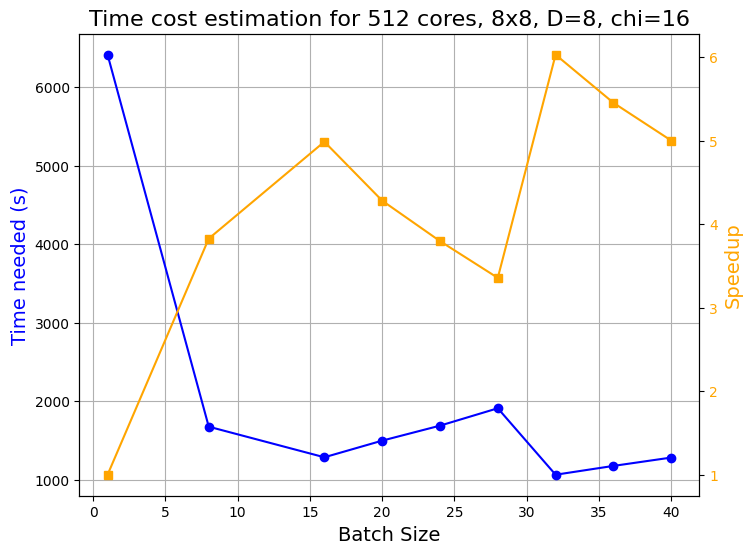

In [14]:
# assuming we have 1000 cores fixed, calculate time needed to get 20000 samples for each batch size
# and plot
# note that each core needs to at least run 1 MC step, so there is a minimum time per batch size - increasing batch size does not unlimitedly reduce time
fixed_cores = 512
# asume we need 20000 samples in total
sample_size = 15000
# # calculate how much cores we need for each batch size, assuming doing only 1 step of MC sampling
# num_cores_list = [sample_size // B for B in B_list]

samples_per_core = sample_size // fixed_cores
adjusted_time_list = []
mc_steps_needed_list = []
for i, B in enumerate(B_list):
    mc_steps_needed = (samples_per_core + B - 1) // B  # ceiling division
    mc_steps_needed_list.append(mc_steps_needed)
    adjusted_time = time_list[i] * mc_steps_needed * 4 * nsites + grad_time_list[i] * mc_steps_needed
    adjusted_time_list.append(adjusted_time*2)
actual_samples_per_core = [B*((sample_size // fixed_cores + B - 1) // B) for B in B_list]
actual_total_samples = [(sample_size // B + 1) * B for B in B_list]

# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(B_list, adjusted_time_list, marker='o', color='blue')
ax.set_xlabel('Batch Size', fontsize=14)
ax.set_ylabel('Time needed (s)', fontsize=14, color='blue')
ax.set_title(f'Time cost estimation for {fixed_cores} cores, {Lx}x{Ly}, D={D}, chi={model.chi}', fontsize=16)
ax.grid(True)
# plot speedup compare to using only B=1
ax2 = ax.twinx()
ax2.plot(B_list, [adjusted_time_list[0]/t for t in adjusted_time_list], color='orange', marker='s')
ax2.set_ylabel('Speedup', color='orange', fontsize=14)
ax2.tick_params(axis='y', labelcolor='orange')
# ax2.set_yscale('log')

# plt.xticks(B_list)
plt.savefig(f'./data/fPEPS_Transformer_batchsize_vs_time_{Lx}x{Ly}_D={D}_chi={model.chi}.png', dpi=300)

In [15]:
# Define column widths
w1, w2, w3, w4, w5 = 6, 25, 18, 20, 15

# Print Header
header = (
    f"{'B':^{w1}} || "
    f"{'actual_samples/core':^{w2}} || "
    f"{'mc_steps':^{w3}} || "
    f"{'adj_time':^{w4}} || "
    f"{'total_samples':^{w5}}"
)
print(header)
print("-" * len(header))

# Print Data
for i in range(len(B_list)):
    print(
        f"{B_list[i]:>{w1}.2f} || "               # Fixed float width for B
        f"{actual_samples_per_core[i]:>{w2}} || " # Integer alignment
        f"{mc_steps_needed_list[i]:>{w3}} || "     # Integer alignment
        f"{adjusted_time_list[i]:>{w4}.4f} || "   # 4 decimal places
        f"{actual_total_samples[i]:>{w5}}"
    )

# Save the form as a text file
with open(f'./data/fPEPS_Transformer_batchsize_vs_time_{Lx}x{Ly}_D={D}_chi={model.chi}.txt', 'w') as file:
    print(f'{Lx}x{Ly} t={t} U={U} N={N_f} D={D} chi={model.chi} Transformer_fPEPS_Model_batchedAttn\n', file=file)
    # Write Header
    file.write(header + '\n')
    file.write("-" * len(header) + '\n')

    # Write Data
    for i in range(len(B_list)):
        file.write(
            f"{B_list[i]:>{w1}.2f} || "               # Fixed float width for B
            f"{actual_samples_per_core[i]:>{w2}} || " # Integer alignment
            f"{mc_steps_needed_list[i]:>{w3}} || "     # Integer alignment
            f"{adjusted_time_list[i]:>{w4}.4f} || "   # 4 decimal places
            f"{actual_total_samples[i]:>{w5}}\n"
        )

  B    ||    actual_samples/core    ||      mc_steps      ||       adj_time       ||  total_samples 
----------------------------------------------------------------------------------------------------
  1.00 ||                        29 ||                 29 ||            6412.5587 ||           15001
  8.00 ||                        32 ||                  4 ||            1675.2308 ||           15008
 16.00 ||                        32 ||                  2 ||            1285.5342 ||           15008
 20.00 ||                        40 ||                  2 ||            1497.4079 ||           15020
 24.00 ||                        48 ||                  2 ||            1688.3337 ||           15024
 28.00 ||                        56 ||                  2 ||            1909.7966 ||           15008
 32.00 ||                        32 ||                  1 ||            1063.3652 ||           15008
 36.00 ||                        36 ||                  1 ||            1175.6191 ||       

In [ ]:
from vmc_torch.experiment.vmap.vmap_utils import sample_next, evaluate_energy, compute_grads
B = 40
fxs = []
for _ in range(B):
    fxs.append(random_initial_config(nsites, nsites))
fxs = torch.stack(fxs, dim=0)
model = Transformer_fPEPS_Model_batchedAttn(
        tn=peps,
        max_bond=D,
        nn_eta=1,
        nn_hidden_dim=peps.nsites,
        embed_dim=16,
        attn_heads=4,
        dtype=torch.float64,
    )
t0 = time.time()
fxs, current_amps = sample_next(fxs, model, H.graph, verbose=True)
energy_batch, local_energies_batch =evaluate_energy(fxs, model, H, current_amps=current_amps, verbose=True)
grads_vec_batch, amps_batch = compute_grads(fxs, model, vectorize=True, batch_size=B, vmap_grad=True)
t1 = time.time()
print('Time (B=%d): %.4f s'%(B, t1 - t0))

In [ ]:
from vmc_torch.experiment.vmap.vmap_utils import sample_next, evaluate_energy, compute_grads
B = 40
fxs = []
for _ in range(B):
    fxs.append(random_initial_config(nsites, nsites))
fxs = torch.stack(fxs, dim=0)
model = Transformer_fPEPS_Model_Conv2d(
        tn=peps,
        max_bond=D,
        nn_eta=1,
        nn_hidden_dim=peps.nsites,
        embed_dim=16,
        attn_heads=4,
        dtype=torch.float64,
    )
t0 = time.time()
fxs, current_amps = sample_next(fxs, model, H.graph, verbose=True)
energy_batch, local_energies_batch =evaluate_energy(fxs, model, H, current_amps=current_amps, verbose=True)
grads_vec_batch, amps_batch = compute_grads(fxs, model, vectorize=True, batch_size=B, vmap_grad=True)
t1 = time.time()
print('Time (B=%d): %.4f s'%(B, t1 - t0))

 -> Clamping output layer (Conv2d) weights to scale 1e-05


/home/sijingdu/TNVMC/VMC_code/clean_symmray/lib/python3.12/site-packages/torch/nn/functional.py:6487: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_flash_attention_for_cpu. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  attn_output = scaled_dot_product_attention(


Time (B=40): 84.5855 s


/home/sijingdu/TNVMC/VMC_code/clean_symmray/lib/python3.12/site-packages/torch/autograd/graph.py:841: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_flash_attention_for_cpu_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [49]:
from vmc_torch.experiment.vmap.vmap_utils import flatten_params
from torch.utils._pytree import tree_map, tree_flatten

def compute_grads_decoupled(fxs, fpeps_model, batch_size=None):
    """
    解耦合梯度计算 (支持 Chunking 以节省内存)：
    Step 1: 前向计算 NN, 拿到数值上的 delta_P (backflow correction)
    Step 2: 计算 TN 的梯度 (分批 vmap, 拿到 sensitivity vector)
    Step 3: 将 sensitivity vector 回传给 NN (VJP, 逐样本循环)
    """
    B = fxs.shape[0]
    dtype = fpeps_model.dtype
    
    # 确定 chunk size，如果未指定则一次性算完
    B_grad = batch_size if batch_size is not None else B
    
    # === 准备参数 ===
    ftn_params = list(fpeps_model.ftn_params)
    nn_params = list(fpeps_model.nn_backflow.parameters())
    nn_params_dict = dict(zip(fpeps_model.nn_param_names, nn_params))

    # =================================================================
    # Step 1: NN Forward (Native Batch)
    # 目的：获取 delta_P 的数值，作为 TN 的输入。
    # =================================================================
    # 这一步通常内存占用不大（相比 TN），所以我们可以一次性算完。
    # 如果显存非常吃紧，也可以把这一步放入下面的循环中，但逻辑会稍微复杂一点。
    with torch.no_grad():
        batch_delta_p = torch.func.functional_call(
            fpeps_model.nn_backflow, nn_params_dict, fxs.to(dtype)
        )
    # batch_delta_p shape: (B, ftn_params_length)

    # =================================================================
    # Step 2: TN Backward (Chunked vmap over grad)
    # 目的：计算 psi 对 delta_P 的敏感度 (Sensitivity)
    # =================================================================
    
    # 定义纯 TN 收缩函数
    def tn_only_func(x_i, ftn_p_list, delta_p_i):
        amp = fpeps_model.tn_contraction(x_i, ftn_p_list, delta_p_i)
        return amp, amp # (Target, Aux)

    # 定义 vmap 函数
    tn_grad_vmap_func = torch.vmap(
        torch.func.grad(tn_only_func, argnums=(1, 2), has_aux=True), 
        in_dims=(0, None, 0)
    )

    # --- 开始 Chunking 循环 ---
    g_ftn_chunks = []
    g_sensitivity_chunks = []
    amps_chunks = []

    for b_start in range(0, B, B_grad):
        b_end = min(b_start + B_grad, B)
        
        # 1. 切片 (Slicing)
        fxs_chunk = fxs[b_start:b_end]
        delta_p_chunk = batch_delta_p[b_start:b_end]
        
        # 2. 计算当前 chunk 的梯度
        # (g_ftn_chunk, g_sensitivity_chunk), amps_chunk
        (g_ftn_c, g_sens_c), amps_c = tn_grad_vmap_func(fxs_chunk, ftn_params, delta_p_chunk)
        
        # 3. 立即 Detach Amps 以释放 TN 计算图 (关键!)
        if amps_c.requires_grad:
            amps_c = amps_c.detach()
            
        # 4. 存储结果
        g_ftn_chunks.append(g_ftn_c)        # 这是一个 list/tuple of tensors
        g_sensitivity_chunks.append(g_sens_c)
        amps_chunks.append(amps_c)
        
        # 显式删除临时变量，辅助 GC
        del g_ftn_c, g_sens_c, amps_c

    # --- 拼接结果 (Aggregation) ---
    
    # 1. 拼接 g_sensitivity (B, Out)
    g_sensitivity = torch.cat(g_sensitivity_chunks, dim=0)
    
    # 2. 拼接 amps (B, 1)
    amps = torch.cat(amps_chunks, dim=0)
    if amps.dim() == 1:
        amps = amps.unsqueeze(-1)

    # 3. 拼接 g_ftn (PyTree 结构)
    # g_ftn_chunks 是一个列表，里面每一个元素都是一个 tuple(tensor_param_1, tensor_param_2, ...)
    # 我们需要把它们按照 parameter 的位置，沿着 dim=0 拼起来
    # 使用 tree_map 可以优雅地处理这个结构
    g_ftn = tree_map(lambda *leaves: torch.cat(leaves, dim=0), *g_ftn_chunks)

    # 此时，TN 部分的大内存已经释放完毕

    # =================================================================
    # Step 3: NN Backward (Sequential Loop)
    # 目的：利用 g_sensitivity 计算 NN 参数的梯度
    # =================================================================
    # 这一步本身就是逐样本的，天然节省内存，直接复用你之前的逻辑即可
    
    g_nn_params_list = []
    
    for i in range(B):
        x_i = fxs[i].unsqueeze(0) 
        g_sens_i = g_sensitivity[i].unsqueeze(0) 
        
        fpeps_model.nn_backflow.zero_grad()
        
        with torch.enable_grad():
            out_i = torch.func.functional_call(
                fpeps_model.nn_backflow, 
                nn_params_dict, 
                x_i.to(dtype)
            )
            target = torch.sum(out_i * g_sens_i.detach())
            grads_i = torch.autograd.grad(target, nn_params, retain_graph=False)
            
        flat_g = flatten_params(grads_i)
        g_nn_params_list.append(flat_g)
        
    g_nn_params_vec = torch.stack(g_nn_params_list)

    # =================================================================
    # Step 4: 拼装最终结果
    # =================================================================
    
    # Flatten g_ftn
    leaves, _ = tree_flatten(g_ftn)
    flat_g_ftn_list = [leaf.flatten(start_dim=1) for leaf in leaves]
    g_ftn_params_vec = torch.cat(flat_g_ftn_list, dim=1)

    g_params_vec = torch.cat([g_ftn_params_vec, g_nn_params_vec], dim=1) # (B, Np_total)
    
    return g_params_vec, amps

g_params_vec, amps = compute_grads_decoupled(fxs, model, batch_size=6)
g_params_vec_benchmark, amps_benchmark = compute_grads(fxs, model, vectorize=True)
g_params_vec.shape, g_params_vec_benchmark.shape
torch.allclose(g_params_vec, g_params_vec_benchmark)

True

In [8]:
import quimb as qu
tn = peps.copy()
params, skeleton = qtn.pack(tn)
# for torch, further flatten pytree into a single list
ftn_params_flat, ftn_params_pytree = qu.utils.tree_flatten(
    params, get_ref=True
)
ftn_params = torch.nn.ParameterList([
    torch.as_tensor(x, dtype=torch.float64) for x in ftn_params_flat
])
ftn_params

ParameterList(
    (0): Parameter containing: [torch.float64 of size 4x2x2x2]
    (1): Parameter containing: [torch.float64 of size 4x2x2x2]
    (2): Parameter containing: [torch.float64 of size 8x2x2x2x2]
    (3): Parameter containing: [torch.float64 of size 8x2x2x2x2]
    (4): Parameter containing: [torch.float64 of size 8x2x2x2x2]
    (5): Parameter containing: [torch.float64 of size 8x2x2x2x2]
    (6): Parameter containing: [torch.float64 of size 4x2x2x2]
    (7): Parameter containing: [torch.float64 of size 4x2x2x2]
)